In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np

#### Noise schedule

In [4]:
beta_start=0.0001
beta_end=0.02
noise_steps=1000

beta = torch.linspace(beta_start, beta_end, noise_steps, dtype=torch.float32)
print("beta shape:",beta.shape)
print("beta max :",beta.max())
print("beta min :",beta.min())


beta shape: torch.Size([1000])
beta max : tensor(0.0200)
beta min : tensor(1.0000e-04)


Text(0, 0.5, '$\\beta$')

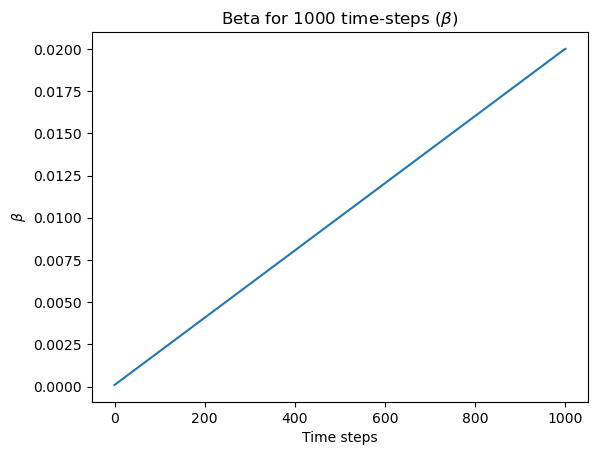

In [5]:
time_step =np.linspace(0,1000,1000).astype("int")
plt.plot(time_step, beta)
plt.title("Beta for 1000 time-steps ($\\beta$)")
plt.xlabel("Time steps")
plt.ylabel("$\\beta$")

As an aside, note that for stable diffusion different parameters are used for the scheduler.max
  - beta_start: 0.00085
  - beta_end: 0.012
  - scaled_linear
    - `torch.linspace(beta_start**0.5, beta_end**0.5, 1000, dtype=torch.float32) ** 2`
  

####  variance schedule  
$\beta, \bar{\alpha}, \sigma$

Sigma max: tensor(25.1461)


Text(0.5, 1.0, 'sigma ($\\sigma$) \n $\\sigma$ == $\\beta$ in ddpm')

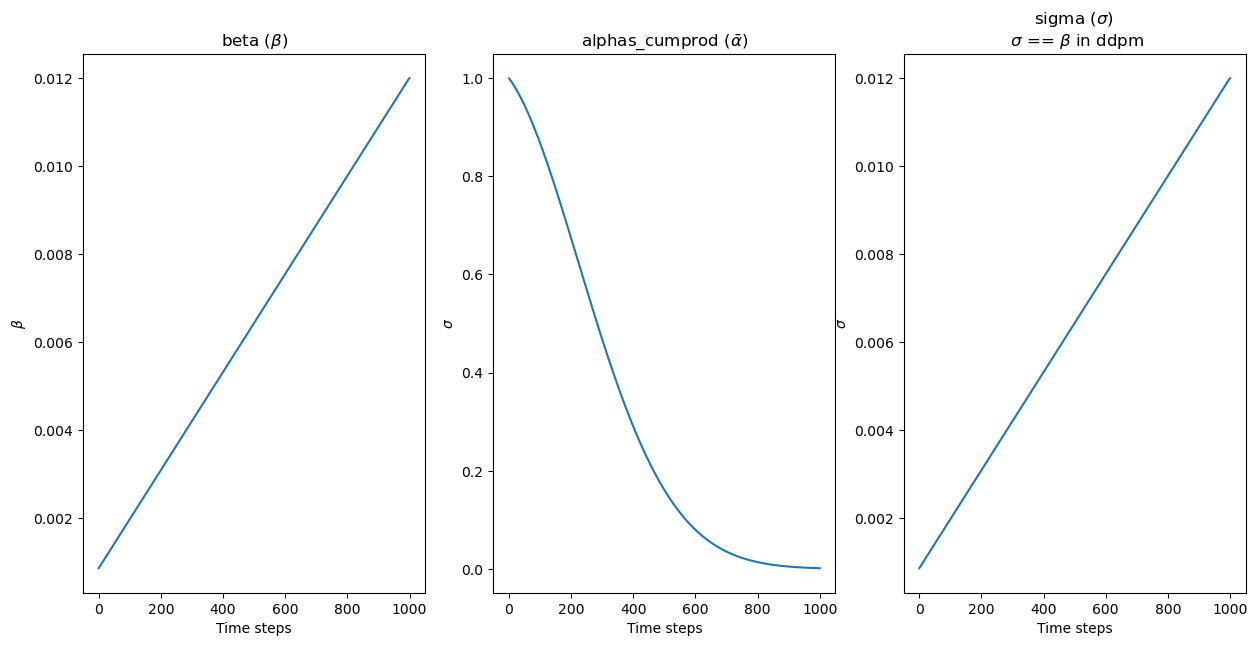

In [15]:
beta_start = 0.00085
beta_end = 0.012
betas =  torch.linspace(beta_start, beta_end, 1000, dtype=torch.float32) 
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)

sigmas = np.array(((1 - alphas_cumprod) / alphas_cumprod) ** 0.5)
sigmas = np.concatenate([sigmas[::-1], [0.0]]).astype(np.float32)
sigmas = torch.from_numpy(sigmas)
print("Sigma max:", sigmas.max())

fig, axs = plt.subplots(1,3,figsize=(15, 7))

time_step = torch.linspace(0,1000,1000,dtype=torch.int)
axs[0].plot(time_step, betas)
axs[0].set(xlabel = "Time steps", ylabel ="$\\beta$")
axs[0].set_title("beta ($\\beta$)")

time_step = torch.linspace(0,1000,1000,dtype=torch.int)
axs[1].plot(time_step, alphas_cumprod)
axs[1].set(xlabel = "Time steps", ylabel ="$\\sigma$")
axs[1].set_title("alphas_cumprod ($\\bar{\\alpha}$)")

time_step = torch.linspace(0,1000,1000,dtype=torch.int)
axs[2].plot(time_step, betas)
axs[2].set(xlabel = "Time steps", ylabel ="$\\sigma$")
axs[2].set_title("sigma ($\\sigma$) \n $\\sigma$ == $\\beta$ in ddpm")

### Sampling

Sample one noisy image at time $t$  

$\sqrt{\bar{\alpha}} x_{t} + \sqrt{1 - \bar{\alpha}}  \epsilon$  

In [19]:
def noise_images(x, t):
    sqrt_alpha_hat = torch.sqrt(alpha_hat[t])[:, None, None, None]
    sqrt_one_minus_alpha_hat = torch.sqrt(1 - alpha_hat[t])[:, None, None, None]
    Ɛ = torch.randn_like(x)
    return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * Ɛ, Ɛ

Algorithm 2 (Sampling)   
![algo 2](images/algo2.jpg)


Step 1  
```
x = torch.randn((n, 3, self.img_size, self.img_size)).to(self.device)
```
  
Step 2  
  
```  
for i in reversed(range(1, 1000)):
```
  
Step 3  
``` 
    if i > 1:
        noise = torch.randn_like(x)                     # z = N(0,1)
    else:
        noise = torch.zeros_like(x)                     # z = 0
```
  
Setting variables  
```
    t = (torch.ones(n) * i).long().to(self.device)      # t
    predicted_noise = model(x, t)                       # E_0
    alpha = self.alpha[t][:, None, None, None]          # alpha
    alpha_hat = self.alpha_hat[t][:, None, None, None]  # alpha_hat 
    beta = self.beta[t][:, None, None, None]            # beta
```
  
Step 4  
  - `1 / torch.sqrt(alpha)`: $\frac{1}{\sqrt{\alpha_{t}}}$  
  - `(1 - alpha) / (torch.sqrt(1 - alpha_hat)`: $\frac{1- \alpha_{t}}{\sqrt{1- \bar{\alpha_{t}}}}$
  - `predicted_noise`:  $\epsilon_{\theta}(x_{t}, t)$  
  - `torch.sqrt(beta)`: $\sqrt{\beta_{t}} == \sigma_{t}$  
  - `noise`: $z$
```
    x = 1 / torch.sqrt(alpha) * \
        (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + \ 
        torch.sqrt(beta) * noise
```           

In [18]:
num_images = 3; ith_iteration = 9
t = (torch.ones(num_images) * ith_iteration); print(t)

tensor([9., 9., 9.])


In [ ]:
def sample(self, model, n):
        logging.info(f"Sampling {n} new images....")
        model.eval()
        with torch.no_grad():
            x = torch.randn((n, 3, self.img_size, self.img_size)).to(self.device)
            for i in tqdm(reversed(range(1, self.noise_steps)), position=0):
                t = (torch.ones(n) * i).long().to(self.device)
                predicted_noise = model(x, t)
                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * \
                    predicted_noise) + torch.sqrt(beta) * noise

### Training

Algorithm 1 Training   
![algo1](images/algo1.jpg)

Step 1  

`for i, (images, _) in enumerate(pbar):`

Step 2 (note that image = x0) 

`x0 = images.to(device)` 

Step 3  

```
  t = diffusion.sample_timesteps(x0.shape[0]).to(device)
    
  def sample_timesteps(self, n):
      return torch.randint(low=1, high=self.noise_steps, size=(n,))  
```
  
Step 4  
  
forward process:  
  - `sqrt_alpha_hat * x0 + sqrt_one_minus_alpha_hat * Ɛ: `$\sqrt{\bar{\alpha}} x_{0} + \sqrt{1- \bar{\alpha}}\epsilon$                            


```  
  x_t, noise = diffusion.noise_images(x0, t)

  def noise_images(self, x0, t):
      sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
      sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
      Ɛ = torch.randn_like(x)
      return sqrt_alpha_hat * x0 + sqrt_one_minus_alpha_hat * Ɛ, Ɛ
```
  
Step 5  
  
reverse process    

```
  predicted_noise = model(x_t, t)
  loss = mse(noise, predicted_noise)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
```

In [ ]:
def train(args):
    setup_logging(args.run_name)
    device = args.device
    dataloader = get_data(args)
    model = UNet().to(device)
    optimizer = optim.AdamW(model.parameters(), lr=args.lr)
    mse = nn.MSELoss()
    diffusion = Diffusion(img_size=args.image_size, device=device)
    logger = SummaryWriter(os.path.join("runs", args.run_name))
    l = len(dataloader)

    for epoch in range(args.epochs):
        logging.info(f"Starting epoch {epoch}:")
        pbar = tqdm(dataloader)
        for i, (images, _) in enumerate(pbar):
            x0 = images.to(device)
            t = diffusion.sample_timesteps(x0.shape[0]).to(device)
            x_t, noise = diffusion.noise_images(x0, t)
            predicted_noise = model(x_t, t)
            loss = mse(noise, predicted_noise)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            pbar.set_postfix(MSE=loss.item())
            logger.add_scalar("MSE", loss.item(), global_step=epoch * l + i)

        sampled_images = diffusion.sample(model, n=images.shape[0])
        save_images(sampled_images, os.path.join("results", args.run_name, f"{epoch}.jpg"))
        torch.save(model.state_dict(), os.path.join("models", args.run_name, f"ckpt.pt"))